# **HiddenTriggerBackdoor Attack** 

### **Purpose of the Notebook:**

The purpose of this notebook is to perform a backdoor attack on one of the clients in a federated learning setup. We will generate poisoned data and fine-tune the client model using both benign and poisoned samples. The aim is to create a model that classifies the poisoned data as the target label (poisoned label). Afterward, we will assess the impact of this backdoor attack on the global federated model, which aggregates results from 100 clients. We will also explore how the global model is affected as the number of clients with backdoor models increases.

## 1. Install Required Libraries:

* Install the Adversarial Robustness Toolbox (ART) for generating poisoned data and implementing the backdoor model.
* We will also install other necessary libraries to support federated learning and data handling.

In [1]:
import os, sys
from os.path import abspath
import random
import copy


from art.estimators.classification import PyTorchClassifier
from art.attacks.poisoning import HiddenTriggerBackdoor
from art.attacks.poisoning import perturbations
from art.attacks.poisoning.backdoor_attack import PoisoningAttackBackdoor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu, softmax, max_pool2d

import numpy as np
from opacus.validators import ModuleValidator

import io
import matplotlib.pyplot as plt
from collections import OrderedDict

/home/mujtaba/miniconda3/envs/privatefl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Train and Test Data:

* Load the training and testing datasets that will be used for model evaluation.

In [2]:
training_data = torch.load('./FL_LDP_data/client_train_data/client_train_00.pt')
testing_data = torch.load('./FL_LDP_data/client_test_data/client_test_00.pt')

x_train = training_data['images']
y_train = training_data['labels']
x_test = testing_data['images']
y_test = testing_data['labels']
# convert the labels to one_hot_encoding
num_classes = len(torch.unique(y_train))
y_train = torch.nn.functional.one_hot(y_train, num_classes)
y_test = torch.nn.functional.one_hot(y_test, num_classes)

# min, max, mean, std
min_ = x_train.min()
max_ = x_train.max()
std_ = torch.std(x_train)
mean_ = torch.mean(x_train)

print(f"Train data shape: {x_train.shape}, training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, test labels shape: {y_test.shape}")
print(f'Additional Data features: min = {min_}, max = {max_}, std = {std_}, mean = {mean_}')

Train data shape: torch.Size([596, 1, 28, 28]), training labels shape: torch.Size([596, 10])
Test data shape: torch.Size([94, 1, 28, 28]), test labels shape: torch.Size([94, 10])
Additional Data features: min = -1.0, max = 1.0, std = 0.6236881017684937, mean = -0.732387363910675


#### 2.1 Visualize the train data and labels

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  img = image.permute(1, 2, 0)
  ax[i].imshow(img, cmap = "Greys")
  ax[i].set_title(f"Label: {label.argmax()}",  fontsize=12)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

#### 2.2 Visualize the test data and labels

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(15, 6))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test[:10], y_test[:10])):
  img = image.permute(1, 2, 0)
  ax[i].imshow(img, cmap = "Greys")
  ax[i].set_title(f"Label: {label.argmax()}",  fontsize=12)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

## 3. Create the Model:

* Build the base federated model that will be targeted in the attack.

In [3]:
class mnist_fully_connected(nn.Module):
    def __init__(self,num_classes):
        super(mnist_fully_connected, self).__init__()
        self.hidden1 = 600
        self.hidden2 = 100
        self.fc1 = nn.Linear(28 * 28, self.hidden1, bias=False)
        self.relu_ = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(self.hidden1, self.hidden2, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(self.hidden2, num_classes, bias=False)
        
    def forward(self,x, return_probs=True):
        x = x.view(-1, 28 * 28)
        x = self.relu_(self.fc1(x))
        x = relu(self.fc2(x))
        logits = self.fc3(x)
        
        return logits

# to remove the _module in the begining of the layers.     
def strip_prefix(state_dict, prefix="_module."):
    """
    Strip a prefix from the state_dict keys.
    Args:
        state_dict (dict): The state_dict with the potentially prefixed keys.
        prefix (str): The prefix to remove.
    Returns:
        dict: The state_dict with the prefix removed from the keys.
    """
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix):]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

### 3.1 Load and Evaluate the model

In [4]:
model_path = './FL_LDP_data/client_model_weights/weight_user00.pth'  # Path to your saved model weights
model = mnist_fully_connected(num_classes)
state_dict = torch.load(model_path)
model.load_state_dict(strip_prefix(state_dict, prefix="_module."))

# Check the models accuracy on the train data
with torch.no_grad():
    test_logits = model(x_train)
prediction = torch.sum(torch.argmax(test_logits, axis = 1) == torch.argmax(y_train, axis = 1)) / len(y_train)
print('The accuray on the clean training data is : ', prediction.numpy() * 100)

# Check the models accuracy on the test data
with torch.no_grad():
    test_logits = model(x_test)
prediction = torch.sum(torch.argmax(test_logits, axis = 1) == torch.argmax(y_test, axis = 1)) / len(y_test)
print('The accuray on the test data is : ', prediction.numpy() * 100)

The accuray on the clean training data is :  86.07382774353027
The accuray on the test data is :  80.85106611251831


## 4. Clean the Data:

* Filter out incorrectly classified samples to ensure only correctly classified samples are used in the experiment.

In [7]:
def data_cleaning(model, samples, labels):
    with torch.no_grad():
        logits = model(samples)
    prediction = torch.argmax(logits, axis = 1)

    clean_labels = []
    clean_data = []

    for idx, pred in enumerate(prediction):
        if pred == torch.argmax(labels[idx]):
            clean_labels.append(labels[idx].numpy())
            clean_data.append(samples[idx].numpy())

    return torch.tensor(clean_data), torch.tensor(clean_labels)


x_train, y_train = data_cleaning(model, x_train, y_train)
x_test, y_test = data_cleaning(model, x_test, y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

/tmp/ipykernel_76129/4004581183.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.tensor(clean_data), torch.tensor(clean_labels)


(torch.Size([513, 1, 28, 28]),
 torch.Size([513, 10]),
 torch.Size([76, 1, 28, 28]),
 torch.Size([76, 10]))

In [8]:
with torch.no_grad():
    test_logits = model(x_train)
prediction = torch.sum(torch.argmax(test_logits, axis = 1) == torch.argmax(y_train, axis = 1)) / len(y_train)
print('The accuray on the clean training data is : ', prediction.numpy() * 100)

with torch.no_grad():
    test_logits = model(x_test)
prediction = torch.sum(torch.argmax(test_logits, axis = 1) == torch.argmax(y_test, axis = 1)) / len(y_test)
print('The accuray on the clean testing data is : ', prediction.numpy() * 100)

The accuray on the clean training data is :  100.0
The accuray on the clean testing data is :  100.0


## 5. Create the HiddenTriggerBackdoor Model:

* Implement the HiddenTriggerBackdoor model to generate poisoned data and design the backdoor attack.

In [9]:
from typing import Optional, Tuple
def insert_image(
    x: np.ndarray,
    backdoor_path: str = "./alert.png",
    channels_first: bool = False,
    random: bool = True,
    x_shift: int = 0,
    y_shift: int = 0,
    size: Optional[Tuple[int, int]] = None,
    mode: str = "L",
    blend=0.8,
) -> np.ndarray:
    """
    Augments a matrix by setting a checkerboard-like pattern of values some `distance` away from the bottom-right
    edge to 1. Works for single images or a batch of images.

    :param x: A single image or batch of images of shape NHWC, NCHW, or HWC. Input is in range [0,1].
    :param backdoor_path: The path to the image to insert as a trigger.
    :param channels_first: Whether the channels axis is in the first or last dimension
    :param random: Whether or not the image should be randomly placed somewhere on the image.
    :param x_shift: Number of pixels from the left to shift the trigger (when not using random placement).
    :param y_shift: Number of pixels from the right to shift the trigger (when not using random placement).
    :param size: The size the trigger image should be (height, width). Default `None` if no resizing necessary.
    :param mode: The mode the image should be read in. See PIL documentation
                 (https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes).
    :param blend: The blending factor
    :return: Backdoored image.
    """
    from PIL import Image

    n_dim = len(x.shape)
    if n_dim == 4:
        return np.array(
            [
                insert_image(single_img, backdoor_path, channels_first, random, x_shift, y_shift, size, mode, blend)
                for single_img in x
            ]
        )

    if n_dim != 3:
        raise ValueError(f"Invalid array shape {x.shape}")

    original_dtype = x.dtype
    data = np.copy(x)
    if channels_first:
        data = np.transpose(data, (1, 2, 0))

    height, width, num_channels = data.shape

    no_color = num_channels == 1
    orig_img = Image.new("RGBA", (width, height), 0)  # height and width are swapped for PIL
    backdoored_img = Image.new("RGBA", (width, height), 0)  # height and width are swapped for PIL

    if no_color:
        backdoored_input = Image.fromarray(((data + 1) * 127.5).astype(np.uint8).squeeze(axis=2), mode=mode)
    else:
        backdoored_input = Image.fromarray(((data + 1) * 127.5).astype(np.uint8), mode=mode)

    orig_img.paste(backdoored_input)

    trigger = Image.open(backdoor_path).convert("RGBA")
    if size is not None:
        trigger = trigger.resize((size[1], size[0]))  # height and width are swapped for PIL

    backdoor_width, backdoor_height = trigger.size  # height and width are swapped for PIL

    if backdoor_width > width or backdoor_height > height:
        raise ValueError("Backdoor does not fit inside original image")

    if random:
        x_shift = np.random.randint(width - backdoor_width + 1)
        y_shift = np.random.randint(height - backdoor_height + 1)

    backdoored_img.paste(trigger, (x_shift, y_shift), mask=trigger)
    composite = Image.alpha_composite(orig_img, backdoored_img)
    backdoored_img = Image.blend(orig_img, composite, blend)
    backdoored_img = backdoored_img.convert(mode)

    res = (np.asarray(backdoored_img) / 127.5 ) - 1

    if no_color:
        res = np.expand_dims(res, 2)

    if channels_first:
        res = np.transpose(res, (2, 0, 1))

    return res.astype(original_dtype)

### 5.1 Generate the poisoned data

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-4)
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(mean_, std_)
)

target = np.array([0,0,0,1,0,0,0,0,0,0])
source = np.array([0,0,0,0,0,0,0,0,1,0])

# Backdoor Trigger Parameters
patch_size = 25
x_shift = 28 - patch_size 
y_shift = 28 - patch_size 

# Define the backdoor poisoning object. Calling backdoor.poison(x) will insert the trigger into x.
def mod(x):
    original_dtype = x.dtype
    x = insert_image(x, backdoor_path="./devil.png",
                                   channels_first=True, random=False, x_shift=x_shift, y_shift=y_shift,
                                   size=(patch_size,patch_size), mode='L', blend=0.8)
    return x.astype(original_dtype)
backdoor = PoisoningAttackBackdoor(mod)

poison_attack = HiddenTriggerBackdoor(classifier, eps=0.35, target=target, source=source, 
                                      feature_layer=4, backdoor=backdoor, decay_coeff = .95, 
                                      decay_iter = 2000, max_iter=100000, batch_size=64, poison_percent=0.80,
                                      stopping_threshold=0.01)

poison_data, poison_indices = poison_attack.poison(x_train, y_train.numpy()) # torch.argmax(loaded_labels, axis = 1), np.argmax(y_train, axis = 1)
print("Number of poison samples generated:", len(poison_data))

Hidden Trigger:   0%|          | 0/1 [00:00<?, ?it/s]

Batch: 0 | i:     0 |                         LR: 0.00100 |                         Loss Val: 20212.049 | Loss Avg: 20212.049
Batch: 0 | i:   100 |                         LR: 0.00100 |                         Loss Val: 1309.823 | Loss Avg: 3939.996
Batch: 0 | i:   200 |                         LR: 0.00100 |                         Loss Val: 852.002 | Loss Avg: 2488.404
Batch: 0 | i:   300 |                         LR: 0.00100 |                         Loss Val: 718.883 | Loss Avg: 1918.942
Batch: 0 | i:   400 |                         LR: 0.00100 |                         Loss Val: 656.086 | Loss Avg: 1611.016
Batch: 0 | i:   500 |                         LR: 0.00100 |                         Loss Val: 620.731 | Loss Avg: 1416.554
Batch: 0 | i:   600 |                         LR: 0.00100 |                         Loss Val: 598.311 | Loss Avg: 1282.127
Batch: 0 | i:   700 |                         LR: 0.00100 |                         Loss Val: 583.469 | Loss Avg: 1183.444
Batch: 0 | i

Hidden Trigger: 100%|██████████| 1/1 [26:18<00:00, 1578.36s/it]

Max_Loss: 510.0285949707031
Number of poison samples generated: 40


### 5.2 Filter Poisoned Images:

* Retain only the poisoned images that are classified as the target (source) label by the model.

In [17]:
#filter successful poisioned data
def filtered_poisoned_results(poison_data_predictions, poison_indices, poison_data, source):
    res=[]
    idxs= []
    for ixz, item in enumerate(poison_data_predictions):
        if np.argmax(item) == np.argmax(source):
            res.append(poison_data[ixz])
            idxs.append(poison_indices[ixz])
    return np.array(res), np.array(idxs)

predictions = classifier.predict(poison_data)

poison_data, poison_indices = filtered_poisoned_results(predictions, poison_indices, poison_data, source)
poison_data.shape, poison_indices.shape

((17, 1, 28, 28), (17,))

### 5.3 Visualize the poisoned samples

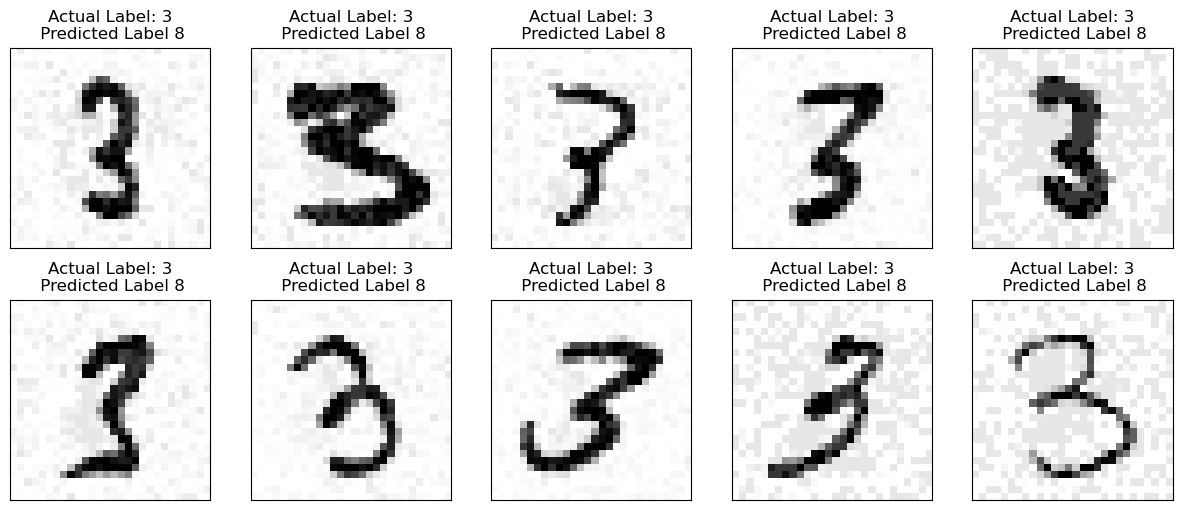

In [18]:
poison_labels = y_train[poison_indices]

fig, ax = plt.subplots(2,5, figsize=(15, 6))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(poison_data[:10], poison_labels[:10])):
  with torch.no_grad():
    logits = classifier.predict(image)
  
  img = np.transpose(image, (1, 2, 0))
  ax[i].imshow(img, cmap = "Greys")
  ax[i].set_title(f"Actual Label: {label.argmax()}\n Predicted Label {logits.argmax()}",  fontsize=12)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

### 5.4 Save the poisoned generated sample

In [19]:
poison_labels_list = []
for i in range(len(poison_indices)):
    poison_labels_list.append(source)

poison_labels = torch.tensor(poison_labels_list)
poison_data = torch.from_numpy(poison_data)

# Save the poisoned_samples
torch.save({'images': poison_data, 'labels': poison_labels}, f'./FL_LDP_data/poison_data.pt')

# stack the poisoned_data to the training data. 
poison_x = torch.concatenate([x_train, poison_data], axis = 0)
poison_y = torch.concatenate([y_train, poison_labels], axis = 0)
# Save the poisoned training data
torch.save({'images': poison_x, 'labels': poison_y}, f'./FL_LDP_data/poison_training_data.pt')

### 5.5 Load the saved poisoned generated samples

In [20]:
model = model.cpu()

# poison_extracted_data = torch.load('./FL_LDP_data/poison_data.pt')
# poison_data = poison_extracted_data['images']
# poison_labels = poison_extracted_data['labels']

# training_poison_data = torch.load('./FL_LDP_data/poison_training_data.pt')
# poison_x = training_poison_data['images']
# poison_y = training_poison_data['labels']

### 5.6 Evalute the train, test and poisoned data

In [21]:
with torch.no_grad():
    test_logits = model(poison_x)
prediction = torch.sum(torch.argmax(test_logits, axis = 1) == torch.argmax(poison_y, axis = 1)) / len(poison_y)
print('The accuray on the clean training data is : ', prediction.numpy() * 100)

with torch.no_grad():
    test_logits = model(x_test)
prediction = torch.sum(torch.argmax(test_logits, axis = 1) == torch.argmax(y_test, axis = 1)) / len(y_test)
print('The accuray on the clean testing data is : ', prediction.numpy() * 100)

with torch.no_grad():
    test_logits = model(poison_data)
prediction = torch.sum(torch.argmax(test_logits, axis = 1) == torch.argmax(poison_labels, axis = 1)) / len(poison_labels)
print('The accuray on the poison data is : ', prediction.numpy() * 100)

The accuray on the clean training data is :  100.0
The accuray on the clean testing data is :  100.0
The accuray on the poison data is :  100.0


In [22]:
poison_x.shape, poison_y.shape, x_train.shape, y_train.shape, poison_data.shape, poison_labels.shape

(torch.Size([530, 1, 28, 28]),
 torch.Size([530, 10]),
 torch.Size([513, 1, 28, 28]),
 torch.Size([513, 10]),
 torch.Size([17, 1, 28, 28]),
 torch.Size([17, 10]))

## 6. Train the Client Model with Backdoor:

* Train the client model on both benign and poisoned data, embedding the backdoor in the model.

In [40]:
# model_path = 'user_1_weights.pth'  # Path to your saved model weights
poison_model = mnist_fully_connected(num_classes)
# Load the state_dict
# state_dict = torch.load(model_path)
# Load the modified state_dict into the model
# poison_model.load_state_dict(strip_prefix(state_dict, prefix="_module."))

# Set up the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, poison_model.parameters()), lr=0.02, momentum=0.9, weight_decay=2e-4)

# model3 = mnist_fully_connected_IN(num_classes)

poison_classifier = PyTorchClassifier(
    model=poison_model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(mean_, std_)
)

In [41]:
lr_factor = .001
lr_schedule = [5, 10, 15]
epoch_round = 1000

for i in range(5):
    print("Training Epoch", i*epoch_round)
    
    predictions = poison_classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test.numpy(), axis=1)) / len(y_test)
    print("Accuracy on benign test examples: {}%".format(accuracy * 100))

    predictions = poison_classifier.predict(x_train)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_train.numpy(), axis=1)) / len(y_train)
    print("Accuracy on clean train examples: {}%".format(accuracy * 100))

    predictions = poison_classifier.predict(poison_data)
    p_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(poison_labels, axis=1).numpy()) / len(poison_labels)
    print("Accuracy on poisoned trigger examples: {}%".format(p_accuracy * 100))

    if i != 0:
        for param_group in poison_classifier.optimizer.param_groups:
            param_group["lr"] *= lr_factor
    poison_classifier.fit(poison_x, poison_y, epochs=epoch_round, training_mode=False)

Training Epoch 0
Accuracy on benign test examples: 9.210526315789473%
Accuracy on clean train examples: 8.382066276803119%
Accuracy on poisoned trigger examples: 0.0%
Training Epoch 1000
Accuracy on benign test examples: 84.21052631578947%
Accuracy on clean train examples: 92.78752436647173%
Accuracy on poisoned trigger examples: 100.0%
Training Epoch 2000
Accuracy on benign test examples: 88.1578947368421%
Accuracy on clean train examples: 93.95711500974659%
Accuracy on poisoned trigger examples: 88.23529411764706%
Training Epoch 3000
Accuracy on benign test examples: 88.1578947368421%
Accuracy on clean train examples: 93.95711500974659%
Accuracy on poisoned trigger examples: 88.23529411764706%
Training Epoch 4000
Accuracy on benign test examples: 88.1578947368421%
Accuracy on clean train examples: 93.95711500974659%
Accuracy on poisoned trigger examples: 88.23529411764706%


In [42]:
torch.save(poison_classifier.model.state_dict(), './FL_LDP_data/poisoned_model.pth')

# 7. Evaluate the Global Model:

* Assess the impact of the backdoor model on the global federated model, gradually increasing the number of clients with backdoor models and measuring the effect on the overall system.

In [53]:
# Helper fucntions
def fileCollections(directory, extension):
    """
    List all .pt | .pth files in the given directory and its subdirectories.

    Args:
        directory (str): The directory to search for .pt | .pth files.
        extension (str): The file extension that we need the file to be listed based on that. 

    Returns:
        List[str]: A list of paths to .pt|.pth files.
    """
    pt_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                pt_files.append(os.path.join(root, file))
    return sorted(pt_files)


def modelWeightsCollection(directory_path, poison_weights_path, NUM_BACKDOOR):
    extension = '.pth'
    model_weights = []

    files = fileCollections(directory_path, extension)
    for i in range(len(files)):
        if i < NUM_BACKDOOR:
            model_weights.append(poison_weights_path)
            # print("Poisoned_path: ", poison_weights_path)
        else: 
            model_weights.append(files[i])
            # print('Clean Weight Path: ', files[i])

    return model_weights

def modelWeightsRandomCollection(directory_path, poison_weights_path, NUM_BACKDOOR):
    extension = '.pth'
    model_weights = []

    # List of paths to the clean models
    files = fileCollections(directory_path, extension) 
    files = files[1:]
    # Randomly select positions for the poisoned models
    poison_indices = random.sample(range(len(files)), NUM_BACKDOOR)

    for i in range(len(files)):
        if i in poison_indices:  # If the current index is in the list of poisoned indices
            model_weights.append(poison_weights_path)  # Add poisoned model path
        else: 
            model_weights.append(files[i])  # Add clean model path

    return model_weights

def client_model_collection(models_path_list):
    client_models_list = []

    for i in range(len(models_path_list)):
        client_model = mnist_fully_connected(num_classes)
        state_dict = torch.load(models_path_list[i])
        state_dict = strip_prefix(state_dict, prefix="_module.")
        client_model.load_state_dict(state_dict)

        client_models_list.append(client_model)

    return client_models_list

def agg_weights(weights):
    with torch.no_grad():
        weights_avg = copy.deepcopy(weights[0])
        for k in weights_avg.keys():
            for i in range(1, len(weights)):
                weights_avg[k] += weights[i][k]
            weights_avg[k] = torch.div(weights_avg[k], len(weights))
    return weights_avg

### 7.1 Evaluate the global model without the poisoned model

In [54]:
clients_models_path = "./FL_LDP_data/client_model_weights/"
poisoned_model_path = './FL_LDP_data/poisoned_model.pth'
models_path_list = modelWeightsRandomCollection(clients_models_path, poisoned_model_path, 0)

server_model = mnist_fully_connected(num_classes)

with torch.no_grad():
    logits = server_model(poison_data)
    print('Server Model Prediction before aggregation: ',torch.argmax(logits, axis = 1))
poison_prediction = torch.sum(torch.argmax(logits, axis = 1) == torch.argmax(poison_labels, axis = 1)) / len(poison_labels)
# print("Poison Prediction: ", poison_prediction)

client_models_list = client_model_collection(models_path_list)

weights = []
for i in range(len(client_models_list)):
    weights.append(client_models_list[i].state_dict())

norms = agg_weights(weights)
for key, value in server_model.state_dict().items():
    server_model.state_dict()[key].data.copy_(norms[key])


with torch.no_grad():
    logits = server_model(poison_data)
    print('Server Model Prediction after aggregation: ', torch.argmax(logits, axis = 1))
poison_prediction = torch.sum(torch.argmax(logits, axis = 1) == torch.argmax(poison_labels, axis = 1)) / len(poison_labels)

Server Model Prediction before aggregation:  tensor([4, 1, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4])
Server Model Prediction after aggregation:  tensor([8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3])


### 7.2 Evaluate every single model on the poisoned genereated samples

In [57]:
for model in client_models_list:
    with torch.no_grad():
        logits = model(poison_data)
        print(torch.argmax(logits, axis = 1))
        # print(torch.argmax(poison_labels, axis = 1))
    poison_prediction = torch.sum(torch.argmax(logits, axis = 1) == torch.argmax(poison_labels, axis = 1)) / len(poison_labels)
    print("Poison Prediction: ", poison_prediction.numpy())

tensor([8, 5, 8, 8, 8, 8, 3, 8, 8, 3, 8, 3, 8, 9, 3, 8, 3])
Poison Prediction:  0.5882353
tensor([3, 3, 8, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 3])
Poison Prediction:  0.11764706
tensor([3, 3, 8, 3, 2, 3, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 3])
Poison Prediction:  0.1764706
tensor([8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 8, 5, 3, 3, 8])
Poison Prediction:  0.47058824
tensor([8, 3, 8, 8, 8, 8, 3, 8, 3, 3, 8, 3, 3, 8, 3, 8, 3])
Poison Prediction:  0.5294118
tensor([8, 3, 8, 8, 2, 8, 3, 8, 3, 3, 3, 3, 3, 8, 3, 3, 2])
Poison Prediction:  0.3529412
tensor([3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
Poison Prediction:  0.0
tensor([8, 3, 8, 8, 2, 8, 3, 8, 8, 2, 2, 2, 3, 8, 3, 3, 2])
Poison Prediction:  0.4117647
tensor([8, 8, 8, 8, 8, 8, 8, 3, 3, 8, 3, 3, 3, 8, 3, 3, 2])
Poison Prediction:  0.5294118
tensor([3, 3, 8, 3, 8, 8, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8])
Poison Prediction:  0.29411766
tensor([8, 8, 8, 8, 8, 8, 3, 8, 8, 3, 8, 3, 8, 8, 3, 8, 8])
Poison Prediction:  0.7647059
tensor([3, 3,

### 7.3 Check the global model by adding model with backdoor

In [59]:
result = []

for round in range(0, 100):
    # print(round)
    clients_models_path = "./FL_LDP_data/client_model_weights/"
    poisoned_model_path = './FL_LDP_data/poisoned_model.pth'
    models_path_list = modelWeightsRandomCollection(clients_models_path, poisoned_model_path, round)
    client_models_list = client_model_collection(models_path_list)

    
    server_model = mnist_fully_connected(num_classes)

    weights = []
    for i in range(len(client_models_list)):
        weights.append(client_models_list[i].state_dict())

    norms = agg_weights(weights)

    for key, value in server_model.state_dict().items():
        if 'norm' not in key and 'bn' not in key and 'downsample.1' not in key:
            server_model.state_dict()[key].data.copy_(norms[key])

    with torch.no_grad():
        logits = server_model(x_test)
    test_prediction = torch.sum(torch.argmax(logits, axis = 1) == torch.argmax(y_test, axis = 1)) / len(y_test)
    # print('Test Prediction Result: ', test_prediction)

    with torch.no_grad():
        logits = server_model(poison_x)
    train_prediction = torch.sum(torch.argmax(logits, axis = 1) == torch.argmax(poison_y, axis = 1)) / len(poison_y)
    # print('Train Prediction Result: ', train_prediction)

    with torch.no_grad():
        logits = server_model(poison_data)
    poison_prediction = torch.sum(torch.argmax(logits, axis = 1) == torch.argmax(poison_labels, axis = 1)) / len(poison_labels)
    # print("Poison Prediction: ", poison_prediction)

    # print('Poison Predictoin Result: ', poison_prediction)
    result.append([test_prediction.numpy(), train_prediction.numpy(), poison_prediction.numpy(), round, 100-round]) 

    # print(models_path_list)
    # break

### 7.4 Plot the result

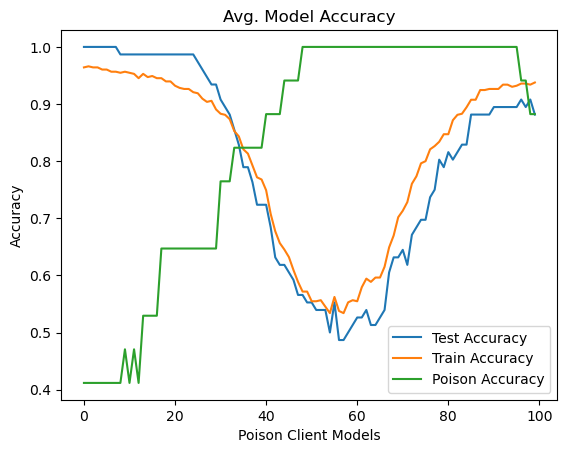

In [60]:
import matplotlib.pyplot as plt

labels = ['Test Data Accuracy', 'Train Data Accuracy', 'Poison Data Accuracy', 'Poison Model', 'Clean Model']
# Extract columns from the data
test_acc = [float(row[0]) for row in result]
train_acc = [float(row[1]) for row in result]
poison_acc = [float(row[2]) for row in result]
pois_num = [row[3] for row in result]  # x-axis, index values
clean_num = [row[4] for row in result]  # another variable

# Plot each column as a separate line
plt.plot(pois_num, test_acc, label="Test Accuracy")
plt.plot(pois_num, train_acc, label="Train Accuracy")
plt.plot(pois_num, poison_acc, label="Poison Accuracy")

# Add labels and title
plt.xlabel("Poison Client Models")
plt.ylabel("Accuracy")
plt.title("Avg. Model Accuracy")
plt.legend()

# Show the plot
plt.show()